# Projeto Teste A/B: estudo de hipóteses

No projeto em tela, observaremos o impacto de alterações feitas no sistema de nossa loja on-line por meio da aplicação de um teste A/B. Esse tipo de teste sugere a exibição de páginas com apresentações diferentes para dois grupos de usuários: um dos grupos, o grupo de controle (grupo A), irá visualizar a versão normalizada da página, sem alterações. O grupo de tratamento ou teste (grupo B) irá visualizar a versão com as alterações que se deseja estudar, de modo a mensurar seu impacto na conversão dos clientes após essa nova implementação.

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Importação e tratamento dos dados

In [2]:
# Importando o dataframe de hipóteses
df_hypotheses = pd.read_csv('./datasets/hypotheses_us.csv', sep=';')

In [3]:
# Verificando as hipóteses
df_hypotheses['Hypothesis'].unique()

array(['Add two new channels for attracting traffic. This will bring 30% more users',
       'Launch your own delivery service. This will shorten delivery time',
       "Add product recommendation blocks to the store's site. This will increase conversion and average purchase size",
       'Change the category structure. This will increase conversion since users will find the products they want more quickly',
       'Change the background color on the main page. This will increase user engagement',
       'Add a customer review page. This will increase the number of orders',
       'Show banners with current offers and sales on the main page. This will boost conversion',
       'Add a subscription form to all the main pages. This will help you compile a mailing list',
       'Launch a promotion that gives users discounts on their birthdays'],
      dtype=object)

Como é possível observar, nosso dataframe de hipóteses contém 9 hipóteses a serem trabalhadas durante a análise. Aplicaremos as metodologias recomendadas para identificar qual das hipóteses deve ser priorizada em nosso estudo.

In [4]:
# Importando o dataframe de pedidos
df_orders = pd.read_csv('./datasets/orders_us.csv', parse_dates=['date'])

In [5]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


No dataframe de pedidos, durante a importação fizemos a conversão das datas da tabela para o tipo datetime64, de modo a facilitar o trabalho com essas datas conforme necessário durante o estudo. Ademais, identificamos que os demais dados se encontram nos formatos adequados para a análise.

In [6]:
# Importando o dataframe de visitas
df_visits = pd.read_csv('./datasets/visits_us.csv', parse_dates=['date'])

In [7]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Assim como feito no dataframe de pedidos, no de visitas também realizamos a conversão das datas para o tipo datetime64. Os demais dados se encontram no formato ideal para a continuação do trabalho.

In [8]:
# Identificando o número máximo de grupos por usuário.
df_orders.groupby('visitorId')['group'].nunique().max()

2

Checamos e observamos acima que existem usuários que estão nos dois grupos. Como o teste deve conter amostras de usuários unívocos em cada um dos grupos, faz-se necessária a remoção desses usuários que estão identificados em ambos os grupos.

In [9]:
# Identificando os usuários duplicados. São aqueles que estão em mais de um grupo.
duplicates = df_orders.groupby('visitorId')['group'].nunique()
duplicates = duplicates[duplicates>1].index

In [10]:
# Visualizando esses usuários duplicados
df_orders[df_orders['visitorId'].isin(duplicates)].sort_values(by=['visitorId', 'group']).head(10)

,transactionId,visitorId,date,revenue,group
703,4293855558,8300375,2019-08-07,30.5,A
71,3679129301,8300375,2019-08-01,165.7,B
26,2223239646,199603092,2019-08-15,55.7,A
134,62794304,199603092,2019-08-22,110.3,A
823,2971973105,199603092,2019-08-27,45.9,A
1102,1941707234,199603092,2019-08-12,100.0,A
246,437656952,199603092,2019-08-02,55.7,B
1013,83566152,232979603,2019-08-31,5.9,A
1009,2670069237,232979603,2019-08-31,45.6,B
41,2594268419,237748145,2019-08-15,20.8,A


Após descobrirmos os números de identificação dos usuários presentes em ambos os grupos, seguimos com a remoção desses usuários da nossa amostra.

In [11]:
# Removendo os usuários duplicados
df_orders = df_orders[~df_orders['visitorId'].isin(duplicates)]

## Estudando as hipóteses

In [12]:
# Visualizando as colunas de hipótese
df_hypotheses.columns

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Effort'], dtype='object')

Acima identificamos as colunas presentes em nossa tabela de hipóteses. Impact, Confidence e Effort são informações necessárias para a aplicação do framework ICE, importante para decidirmos qual das hipóteses deve ter prioridade dentre nossas iniciativas. Em conjunto com a coluna Reach, poderemos utilizar o framework RICE, que, além de nos transmitir as informações anteriores, nos passa o alcance que cada uma das implementações deverá representar ao nosso negócio.

### Framework ICE (Impact. Confidence. Effort)

Iniciaremos nosso estudo pelo cálculo do framework ICE para cada uma de nossas hipóteses.

In [13]:
# Calculando o framework ICE
df_hypotheses['ICE'] = ((df_hypotheses['Impact'] * df_hypotheses['Confidence']) / df_hypotheses['Effort']).round(2)

In [14]:
# Ampliando a largura da coluna que contém a hipótese, para melhor observação.
pd.set_option('display.max_colwidth', None)

In [15]:
# Observando os valores de ICE
df_hypotheses[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.20
0,Add two new channels for attracting traffic. This will bring 30% more users,13.33
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.20
6,Show banners with current offers and sales on the main page. This will boost conversion,8.00
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.00
1,Launch your own delivery service. This will shorten delivery time,2.00
5,Add a customer review page. This will increase the number of orders,1.33
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.12
4,Change the background color on the main page. This will increase user engagement,1.00


Como podemos observar, as hipóteses que, segundo a metodologia ICE, representam maior potencial de valor em nosso estudo são as seguintes:

- Promoção e oferta de descontos aos usuários aniversariantes: 16.20 pontos;
- Adição de dois novos canais de tráfego, o que trará 30% mais usuários: 13.33 pontos;
- Adição de um formulário de inscrição em todas as páginas principais, que ajudará a compilar uma lista de e-mails: 11.20 pontos.

### Framework RICE (Reach. Impact. Confidence. Effort)

A princípio, a hipótese mais sugerida a ser trabalhada em nosso estudo é a de ofertar descontos para os usuários nos dias do seu aniversário. A seguir, por meio da aplicação do framework RICE, que também leva em conta o alcance da medida, iremos nos certificar de qual hipótese é a mais adequada para o estudo.

In [16]:
# Calculando o framework RICE
df_hypotheses['RICE'] = ((df_hypotheses['Reach'] * df_hypotheses['Impact'] * df_hypotheses['Confidence']) / df_hypotheses['Effort'])

In [17]:
# Observando os valores de RICE
df_hypotheses[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


Por meio da aplicação da metodologia RICE, observamos que a hipótese mais sugerida é a de adicionar um formulário de inscrição em todas as páginas principais, a fim de compilar uma lista de e-mails para futuras promoções e retenção de clientes. É notável que essa implementação afetará uma quantidade maior de clientes que a recomendada pela metodologia ICE, que abrangia apenas clientes aniversariantes.

Dessa forma, na comparação entre os dois modelos de framework para análise de hipóteses (ICE e RICE), sugerimos a aplicação do modelo RICE, tendo em vista que esse também abrange o alcance da hipótese, isto é, uma previsão do número de usuários que serão afetados pela implementação.

Sendo assim, a hipótese a ser trabalhada será: **"Adição de um formulário de inscrição em todas as páginas principais, que ajudará a compilar uma lista de e-mails"**.

## Testagem A/B e observação dos dados

A partir de agora, entraremos no estudo efetivo de nossos dados. Iremos identificar que informações importantes eles têm a apresentar para nosso estudo, e quais foram os resultados da aplicação do teste A/B realizado dentre os usuários que visualizaram a versão normalizada do site (grupo de controle - A), e os usuários que visualizaram a versão implementada com a adição de um formulário de inscrição nas páginas principais (grupo de tratamento - B).

In [18]:
# Obtendo as datas e os grupos da tabela de pedidos.
datesGroups = df_orders[['date', 'group']].drop_duplicates()

In [19]:
datesGroups.shape

(62, 2)

Primeiramente, separamos as datas do período de aplicação do teste. Como podemos observar, temos 62 linhas de datas, referentes aos 31 dias do período de realização do teste (mês de agosto) vezes 2, o número de grupos do nosso teste.

A seguir, iremos agregar os dados da nossa tabela de pedidos à tabela anterior de datas, calculando os valores acumulados para o número de transações, de visitantes e a receita total acumulada até aquela data.

In [20]:
# Realizando a agregação das informações de pedidos de forma cumulativa.
ordersAggregated = datesGroups.apply(
    lambda x: df_orders[
        np.logical_and(
            df_orders['date'] <= x['date'], df_orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1).sort_values(by=['date', 'group'])

In [21]:
# Renomeando as colunas
ordersAggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']

In [22]:
# Segregando os grupos A e B
ordersAggregatedA = ordersAggregated[ordersAggregated['group']=='A']
ordersAggregatedB = ordersAggregated[ordersAggregated['group']=='B']

### Receita acumulada e tamanho médio dos pedidos

Separamos as informações acumuladas dos grupos A e B. Nesse momento, vamos calcular e observar os padrões de compras de cada grupo, analisando a receita acumulada por dia para cada um deles, e o tamanho médio acumulado dos pedidos.

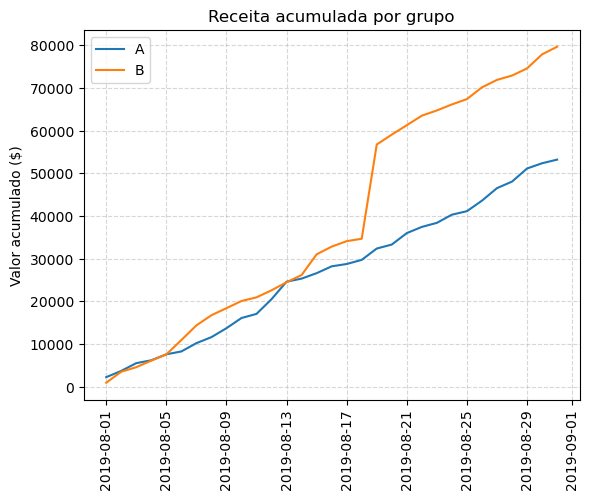

In [23]:
# Construindo o gráfico de receita acumulada do grupo A
plt.plot(ordersAggregatedA['date'], ordersAggregatedA['revenue'], label='A')

# Construindo o gráfico de receita acumulada do grupo B
plt.plot(ordersAggregatedB['date'], ordersAggregatedB['revenue'], label='B')

plt.legend()
plt.title('Receita acumulada por grupo')
plt.ylabel('Valor acumulado ($)')
plt.grid(linestyle='--', alpha=0.5)
plt.xticks(rotation=90)
plt.show()

Podemos notar um pico de receita do dia 18 para o dia 19 de agosto. Devido a esse salto na receita acumulada, o gráfico de receitas do grupo B, que até então estava relativamente pareado ao do grupo A, passa a ter uma grande disparidade de valores em relação ao outro grupo.

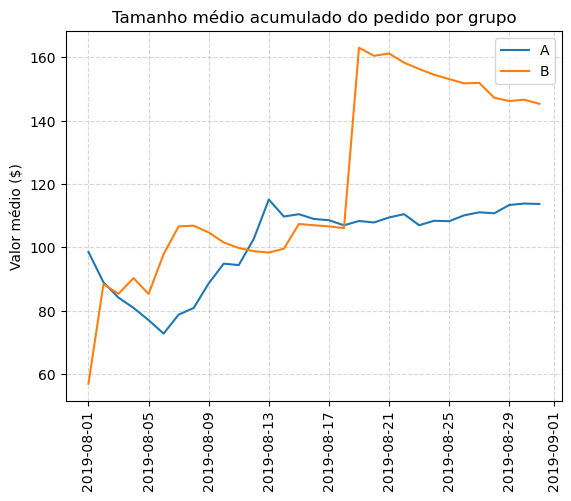

In [24]:
# Construindo o gráfico de tamanho médio do pedido do grupo A
plt.plot(ordersAggregatedA['date'], (ordersAggregatedA['revenue']/ordersAggregatedA['orders']), label='A')

# Construindo o gráfico de tamanho médio do pedido do grupo B
plt.plot(ordersAggregatedB['date'], (ordersAggregatedB['revenue']/ordersAggregatedB['orders']), label='B')

plt.legend()
plt.title('Tamanho médio acumulado do pedido por grupo')
plt.ylabel('Valor médio ($)')
plt.grid(linestyle='--', alpha=0.5)
plt.xticks(rotation=90)
plt.show()

Observamos novamente o pico identificado no dia 19 de agosto, agora em relação ao tamanho médio acumulado dos pedidos. O grupo B realizou compras significativas nesse dia, que fizeram com que houvesse um destaque na disparidade gráfica entre os grupos.

Apesar disso, podemos identificar uma queda no valor médio do grupo B após tal salto, enquanto o grupo A se manteve estável próximo a casa dos $120 por pedido.

### Diferença relativa no tamanho médio acumulado do pedido

Em comparação aos volumes médios de compra observados entre os grupos, vamos utilizar o cálculo da diferença relativa para observar com mais detalhes o real impacto das disparidades gráficas observadas anteriormente.

A diferença relativa compara os valores acumulados dos dois grupos a fim de expressar a diferença entre eles, em termos percentuais. Essa métrica é útil para avaliar o impacto de uma mudança em relação ao valor original, e nos permitirá realizar uma análise mais clara e informativa.

In [25]:
# Reunindo os dados em um dataframe
mergedOrders = ordersAggregatedA.merge(ordersAggregatedB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [26]:
# Podemos remover a informação dos grupos, pois estão identificados nos nomes das colunas.
mergedOrders = mergedOrders.drop(['groupA', 'groupB'], axis=1)

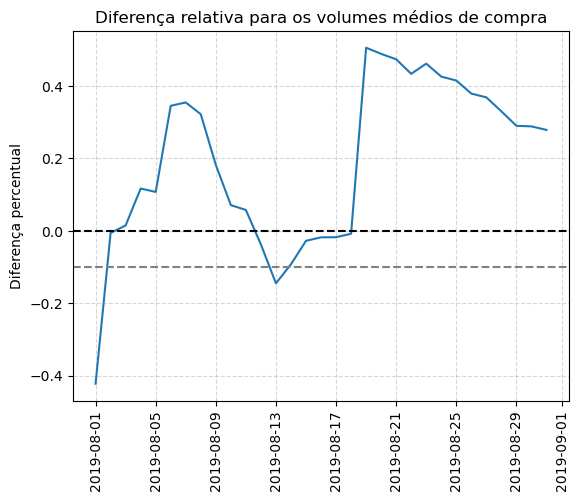

In [27]:
# Construindo um gráfico de diferença relativa para os volumes médios de compra
plt.plot(mergedOrders['date'], (mergedOrders['revenueB']/mergedOrders['ordersB'])/(mergedOrders['revenueA']/mergedOrders['ordersA'])-1)

# Acrescentando o eixo X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.title('Diferença relativa para os volumes médios de compra')
plt.ylabel('Diferença percentual')
plt.grid(linestyle='--', alpha=0.5)
plt.xticks(rotation=90)
plt.show()

No gráfico acima, notamos a tendência de evolução dos pedidos do grupo B ao longo do período estudado. No dia 6 de agosto há o primeiro pico no gráfico, quando o volume médio de compras do grupo B chega a 35% do volume de compras do grupo A.

No dia 13 de agosto, notamos uma queda brusca nos valores do grupo B, quando esse chega a estar cerca de 10% abaixo dos valores do grupo A. Apesar disso, os valores do grupo B tornam a subir novamente, quando observamos mais uma vez o pico de compras do dia 19 de agosto. O volume médio de compras do grupo B nessa data chega a ser quase 50% maior que os valores do grupo A.

Após esse notável período de alta, mais uma vez percebemos uma queda nos valores do grupo B, que não chega a ser vertiginosa por conta do período de 10 dias, caindo de 40% mais valores de vendas que o grupo A para cerca de 30% a mais, o que ainda representa uma disparidade significativa no volume médio das compras.

### Taxa de conversão de clientes

Prosseguimos com nossa análise do teste. Agora, iremos observar a taxa de conversão de cada grupo com a proporção de pedidos para o número de visitas para cada dia. Dessa forma poderemos observar qual dos grupos, além de ter gerado maior receita, é capaz de converter o maior número de visitantes em compradores.

In [28]:
# Realizando a agregação das informações de visitas de forma cumulativa.
visitorsAggregated = datesGroups.apply(
    lambda x: df_visits[
        np.logical_and(
            df_visits['date'] <= x['date'], df_visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visits': 'sum'}),
    axis=1).sort_values(by=['date', 'group'])

In [29]:
visitorsAggregated.head()

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [30]:
# Realizando o merge com as informações de pedidos. Dessa forma, teremos um df com todos os dados cumulativos.
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [31]:
# Dados cumulativos por data e grupo
cumulativeData.head()

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


Inicialmente, criamos um dataframe com as informações cumulativas sobre a quantidade de visitas por data e grupo. Em seguida, realizamos a junção da tabela gerada com os nossos dados cumulativos anteriores referentes aos pedidos. Dessa forma, geramos uma tabela final com todas as informações sobre os números de pedidos e visitas acumulados por dia para cada grupo do nosso teste.

A partir de agora, com essa tabela em mãos, calcularemos a conversão dos dados de pedidos e visitas cumulativos. Assim, poderemos observar a taxa de conversão de clientes por cada data e grupo em separado.

In [32]:
# Gerando uma coluna de Conversão das visitas em pedidos.
cumulativeData['conversion'] = (cumulativeData['orders'] / cumulativeData['visits'])

In [33]:
# Segregando os grupos da tabela cumulativa
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

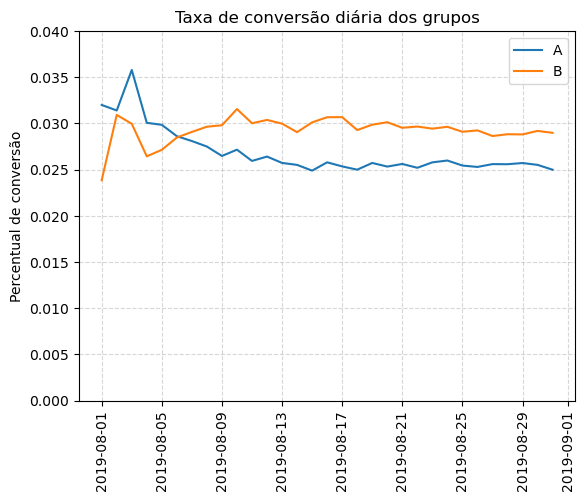

In [34]:
# Construindo o gráfico da taxa de conversão do grupo A 
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')

# Construindo o gráfico da taxa de conversão do grupo B 
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

# Definimos os limites de y para observação
plt.ylim(0, 0.04)

plt.legend()
plt.title('Taxa de conversão diária dos grupos')
plt.ylabel('Percentual de conversão')
plt.grid(linestyle='--', alpha=0.5)
plt.xticks(rotation=90)
plt.show()

Observamos no gráfico da taxa de conversão diária que, nos primeiros cinco dias do período de testes, os valores de conversão do grupo A foram superiores aos do grupo B, com um pico de conversão de 3.5% das visitas diárias em pedidos. A partir do sexto dia, notamos uma reviravolta nos valores, quando o grupo B passa a ter uma taxa de conversão maior que a do grupo A, se mantendo assim até o final do período em análise.

Podemos observar que, de maneira constante, os valores da taxa de conversão do grupo B ficaram na faixa dos 3% de visitas diárias convertidas em pedidos. Por outro lado, a taxa de conversão do grupo A foi de cerca de 2.5% das visitas em pedidos. O grupo B, nesse quesito, apresentou desempenho 0.05% superior ao grupo A no período.

In [35]:
# Reunindo os dados de conversão em um dataframe
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [36]:
# Informações de conversão dos grupos
mergedCumulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


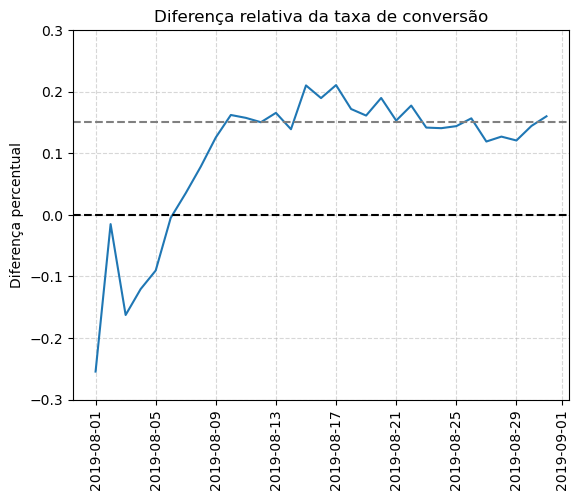

In [37]:
# Construindo o gráfico da diferença relativa na conversão cumulativa dos grupos.
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.ylim(-0.3, 0.3)

plt.title('Diferença relativa da taxa de conversão')
plt.ylabel('Diferença percentual')
plt.grid(linestyle='--', alpha=0.5)
plt.xticks(rotation=90)
plt.show()

Em relação à diferença relativa da taxa de conversão cumulativa entre os grupos, observamos novamente que, até o dia 5 de agosto, o grupo A estava em vantagem em relação ao grupo B, quando detinha cerca de 10% conversões a mais que o outro.

Depois do dia 6, quando as taxas de conversão dos dois grupos se igualam, nota-se o aumento significativo nos valores de conversão do grupo B, invertendo os números anteriores em relação ao grupo A. Dessa forma, os valores da taxa de conversão do grupo B agora estão cerca de 15% superiores aos valores do grupo A, se mantendo nessa faixa ao longo do período em análise, chegando a picos de 20% a mais.

## Identificando anomalias nos dados

Anomalias são dados definidos como outliers, dados tão espaçados dos usualmente vistos em nosso teste que podem interferir nos resultados finais das observações, por estarem desviados significativamente dos demais dados do teste.

Dessa forma, o recomendado é que também se observe as informações desconsiderando essas anomalias. Sendo assim, iremos filtrar os nossos dados e remover aqueles considerados anômalos para nosso estudo.

In [38]:
# Identificando o total de pedidos de cada usuário
ordersByUsers = (
    df_orders.drop(['revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'group': 'max'})
)

ordersByUsers.columns = ['userId', 'orders', 'group']

In [39]:
ordersByUsers.head()

,userId,orders,group
0,5114589,1,B
1,6958315,1,B
2,11685486,1,A
3,39475350,1,B
4,47206413,1,B


### Anomalia no número de pedidos por usuário

In [40]:
# Calculando os percentis 95 e 99 para o número de pedidos por usuário.
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Os valores dos percentis 95 e 99 representam que, respectivamente, apenas 5% dos usuários do sistema fizeram mais de um pedido, e que apenas 1% dos usuários fizeram mais de dois pedidos. No período de um mês, referente ao período do teste até aqui, consideramos esses valores aceitáveis, pois seria curioso observar grandes quantidades de pedidos por usuário em um espaço tão curto de tempo.

### Anomalia nos preços dos pedidos

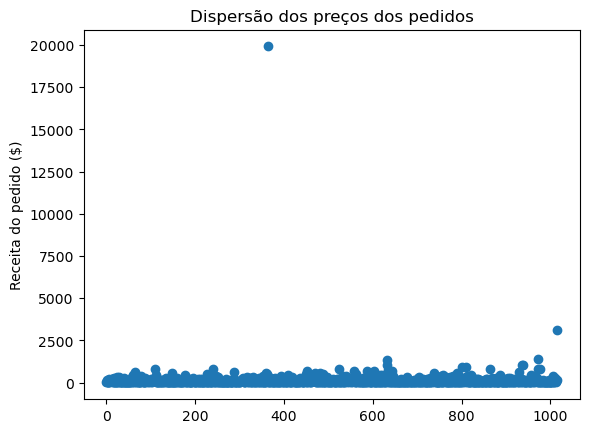

In [41]:
x_values = pd.Series(range(0,len(df_orders)))

plt.scatter(x_values, df_orders['revenue'])
plt.title('Dispersão dos preços dos pedidos')
plt.ylabel('Receita do pedido ($)')
plt.show()

In [42]:
np.percentile(df_orders['revenue'], [95, 99])

array([414.275, 830.3  ])

Como podemos observar no gráfico de dispersão e nos valores dos percentis 95 e 99 expostos acima, 95% dos pedidos do período estão abaixo da faixa dos $414. Além disso, apenas 1% dos pedidos observados superam a marca de 830. Dessa forma, valores de pedidos maiores que os apresentados podem ser considerados anomalias que podem vir a interferir na observação dos nossos dados e nos resultados do teste.

Por sinal, podemos observar, no gráfico de dispersão, que há um pedido único próximo ao valor de $20.000. Esse pedido em específico pode influenciar bastante nos resultados do nosso teste. Prosseguiremos, portanto, com o tratamento dessas anomalias e com a realização de novas observações sobre os grupos.

### Visitantes que não realizaram pedidos

Fica claro também que, em relação aos números de visitas e pedidos, alguns visitantes não realizaram pedidos na plataforma, mas que mesmo assim suas informações entraram em nossa análise. Vamos observar o número de visitantes que não se converteram em clientes, além de tratar seus dados para as observações seguintes.

In [43]:
# Segregando os dados de nº de pedidos dos usuários e removendo a coluna de grupo.
ordersByUsersA = ordersByUsers[ordersByUsers['group']=='A'].drop('group', axis=1)
ordersByUsersB = ordersByUsers[ordersByUsers['group']=='B'].drop('group', axis=1)

In [44]:
# Diferença entre o total de visitas e o número de pedidos.
df_visits[df_visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])

18291

In [45]:
df_visits[df_visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])

18388

Por meio dos dados apresentados acima, observamos que existe uma diferença de 18.291 visitantes do grupo A que não realizaram pedidos em nossa plataforma. Da mesma forma, verificamos que 18.388 visitantes do grupo B também não realizaram pedidos durante o acesso ao site.

A seguir, iremos adicionar linhas ao nosso dataframe do número de pedidos por usuário, com a informação de que essas visitas realizaram zero pedidos durante o acesso à plataforma. O total de linhas adicionadas será o total de visitantes de cada grupo que não realizou nenhum pedido.

In [46]:
# Adicionando as linhas de pedidos zerados ao grupo A.
sampleA = pd.concat(
    [ordersByUsersA['orders'],pd.Series(0, index=np.arange(
        df_visits[df_visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

In [47]:
# Adicionando as linhas de pedidos zerados ao grupo B.
sampleB = pd.concat(
    [ordersByUsersB['orders'],pd.Series(0, index=np.arange(
        df_visits[df_visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

## Descobrindo a significância estatística

In [48]:
# Importando a biblioteca scipy.stats
import scipy.stats as st

Nesse bloco iremos investigar a significância estatística da diferença entre informações dos grupos de controle (grupo A) e de teste (grupo B). Para isso, aplicaremos o teste Mann-Whitney U, que compara duas amostras independentes, às amostras geradas acima, para identificar o valor-p e descobrir se há diferenças ou não entre os valores apresentados.

Aplicaremos dois cálculos nas hipóteses a seguir:

- o do valor-p, para identificar se há diferença entre as amostas. Se o valor-p for menor que o nível de significância de 5%, rejeitamos a hipótese nula (H0) e concluímos que há diferença significativa entre os grupos amostrais;

- a diferença relativa utilizando a razão das médias, que dirá qual a magnitudade dessa diferença amostral.

### Significância estatística da diferença na conversão entre os grupos usando os dados brutos

In [49]:
# Obtendo o valor-p com o teste Mann-Whitney U
st.mannwhitneyu(sampleA, sampleB)[1].round(5)

0.01102

In [50]:
# Obtendo a diferença relativa na conversão.
(sampleB.mean()/sampleA.mean()-1).round(5)

0.1598

Nessa primeira hipótese, verificamos a existência de diferença significativa entre a conversão dos dois grupos utilizando os dados brutos (ainda não filtrados).

No caso acima, o valor-p de 1,1% é inferior ao nível de significância da amostra. Portanto, rejeitamos a hipótese nula e concluímos que há diferença entre a conversão dos grupos amostrais A e B.

O valor da diferença relativa, conforme demonstrado pela razão entre as médias de conversão, é de 15,98% a mais de conversões para o grupo B. Essa informação bate com o que havíamos observado nos gráficos exibidos anteriormente.

### Significância estatística da diferença no tamanho médio do pedido entre os grupos usando os dados brutos

In [51]:
# Obtendo o valor-p com o teste Mann-Whitney U
st.mannwhitneyu(df_orders[df_orders['group']=='A']['revenue'], df_orders[df_orders['group']=='B']['revenue'])[1].round(5)

0.86223

In [52]:
# Obtendo a diferença relativa no tamanho médio do pedido.
(df_orders[df_orders['group']=='B']['revenue'].mean()/df_orders[df_orders['group']=='A']['revenue'].mean()-1).round(5)

0.27834

Em relação ao tamanho médio dos pedidos entre os grupos, o valor-p de 86% indica não existir diferença estatisticamente significativa entre os valores médios dos pedidos dos grupos A e B.

Ainda assim, podemos observar que o tamanho médio dos pedidos do grupo B foi cerca de 28% maior que do grupo A. Isso pode se dar devido a anomalias presentes na amostra do grupo B, como visto anteriormente, que fazem com que não exista evidência suficiente para afirmar que a diferença entre os grupos é real.

## Filtrando os dados das amostras

Vimos anteriormente que apenas 1% dos usuários fizeram mais de dois pedidos no período de estudo. Além disso, apenas 5% dos pedidos eram maiores que $415. Desssa forma, podemos identificar dados que raramente ocorrem como outliers, anomalias que podem interferir sobre as observações do estudo.

Portanto, a seguir iremos filtrar esses dados de nossas amostras, a fim de observar sua influência sobre o estudo e determinar se tiveram grande interferência durante nossas observações anteriores.

In [53]:
# Identificando os usuários com mais de 2 pedidos.
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis=0)

# Identificando os pedidos maiores que $450
usersWithExpensiveOrders = df_orders[df_orders['revenue'] > 450]['visitorId']

# Atribuindo ambos os registros como usuários anômalos.
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

In [54]:
abnormalUsers.shape

(51,)

Identificamos 51 usuários anômalos em nossas amostras. Esses são usuários que fizeram mais que dois pedidos, ou cujos pedidos foram maiores que $450, informações notavelmente incomuns em nossas observações anteriores.

In [55]:
# Filtrando os usuários anômalos do grupo A
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(df_visits[df_visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),
                                       name='orders')],axis=0)

In [56]:
# Filtrando os usuários anômalos do grupo B
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(df_visits[df_visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),
                                       name='orders')],axis=0)

### Significância estatística da diferença na conversão entre os grupos usando os dados filtrados

In [57]:
# Obtendo o valor-p com o teste Mann-Whitney U para os dados filtrados.
st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1].round(5)

0.00962

In [58]:
# Obtendo a diferença relativa na conversão para os dados filtrados.
(sampleBFiltered.mean()/sampleAFiltered.mean()-1).round(5)

0.18771

Observamos que, com os dados agora filtrados, o valor-p de 0,96% permanece bem inferior ao nível de significância, valor semelhante ao de 1,1% dos dados brutos. Dessa forma, também rejeitamos a hipótese nula e concluímos que há diferença entre a conversão dos grupos amostrais A e B, mesmo após a filtragem dos dados.

Mensuramos a diferença relativa no valor de 18,77%, o que demonstra que, após filtrarmos os dados, o grupo B apresentou uma taxa de conversão ainda maior que a observada anteriormente em comparação ao grupo A (com os dados brutos era de cerca de 16%).

### Significância estatística da diferença no tamanho médio do pedido entre os grupos usando os dados filtrados

In [59]:
# Obtendo o valor-p com o teste Mann-Whitney U para os dados filtrados.
st.mannwhitneyu(
    df_orders[np.logical_and(
        df_orders['group']=='A',
        np.logical_not(df_orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    df_orders[np.logical_and(
        df_orders['group']=='B',
        np.logical_not(df_orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1].round(5)

0.7836

In [60]:
# Obtendo a diferença relativa no tamanho médio do pedido para os dados filtrados.
(df_orders[np.logical_and(df_orders['group']=='B',np.logical_not(
    df_orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/df_orders[np.logical_and(df_orders['group']=='A',np.logical_not(
    df_orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1).round(5)

-0.02487

Comparando os tamanhos médios dos pedidos entre grupos, o valor-p de 78,36% mostra novamente que não existe diferença significativa entre os valores médios de pedidos entre os grupos A e B.

Por outro lado, dessa vez observamos que a diferença relativa entre os grupos foi 2,49% maior para o grupo A após a remoção das informações anômalas. Como havíamos identificado anteriormente, o grupo B apresentava valores de outliers que impulsionavam seus valores em relação ao grupo A, mesmo quando nosso teste Mann-Whitney U informava não haver diferença estatisticamente significativa entre os volumes de compra dos dois grupos.

## Conclusão Geral

Feitas as observações e o estudo da análise dos dados dos nossos dois grupos, sugerimos parar com o teste e aplicar a implementação referente ao grupo B, que sugere a implementação de formulários de inscrição nas páginas principais do site.

Como pudemos notar, os dados acima indicaram aumento de cerca de 18% na taxa de conversão de visitantes em compradores após a nova implementação, em comparação à versão original do sistema, sem alterações. Além disso, há estabilidade nos valores de conversões diárias, na faixa dos 3% de conversões.

Além disso, usuários do grupo de tratamento (grupo B) realizaram compras tão altas que tiveram de ser consideradas anômalas durante nossa análise. Cabe seguir acompanhando esse padrão para identificar se a nova implementação foi determinante para os valores altíssimos de compras, que impulsionaram a receita acumulada do grupo no período, mostrando ser muito maior que a do grupo de controle (grupo A).

Por fim, observamos não ter havido diferença estatisticamente significativa entre o tamanho médio das compras dos dois grupos no período, apesar de observarmos valores maiores de compras no grupo B antes da filtragem dos dados brutos.